# <center>Extreme learning machines</center>
***
### <center>*Universidade Federal de Minas Gerais*</center>  
### <center>*Introdução à Inteligência Computacional*</center>  
### <center>*Autores: Álvaro Lemos e Felipe Carvalho*</center>

## ELMs

ELMs are single layer feed forward neural networks (SLFNs). Its hidden layer is made out of several neurons which can have varying activation functions and whose parameters are randomly chosen. They map the input to an orthogonalized space, after it goes through the random single hidden layer, to a problem that is linearly separable.

<center>![ELM as a single layer feed forward network](./images/mlp.png)</center>

The output function of the ELM can be seen as:

\begin{equation}
f_l(\boldsymbol{x}) = \sum_{i=1}^{L}\beta_i h_i(x) = \boldsymbol{h(x)} \boldsymbol{\beta }
\end{equation}

Where $\boldsymbol{\beta}$ is the output weight vector between the hidden layer with L nodes and the output layer, and $\boldsymbol{h(x)}$ is the output of the hidden layer of the ELM, which is a non-linear feature mapping. 


<center>![ELM hidden layer feature mapping](./images/elmfeaturespace.png)</center>


$h(\boldsymbol{x})$, as the output if the hidden layer is generated by the forward pass of inputs $\boldsymbol{x}$ to the hidden layer with random weights $\boldsymbol{w}$ and variable activations, which can be any nonlinear piecewise continuous functions, represented by G.

\begin{equation}
\boldsymbol{h(x)} = G(\boldsymbol{w},\boldsymbol{x})
\end{equation}

Common activation functions for the hidden layer nodes are the sigmoid function, the hyperbolic tangent function, and Gaussian functions (RBF kernel).

The training of an ELM consist of randomly initializing the hidden layer and then finding the coefficients $\boldsymbol{\beta}$ after calculating the non-linear feature space h(x), which is a linear parameter solving task.

The optimal solution for $\boldsymbol{\beta}$ is given as follows:

\begin{equation}
\boldsymbol{\beta} = \boldsymbol{H}^\dagger \boldsymbol{Y}
\end{equation}

Where $\boldsymbol{H}^\dagger$ is the pseudo-inverse of matrix H and $\boldsymbol{Y}$ are the target outputs.

The training speed of an ELM model is very short compared to other state of the art methods such as neural networks or SVMs but still they are able to acheive great results that can in many of the times surpass these methods. This happens because the ELM has only to solve a linear model from its hidden layer to its output layer, therefore being fast, and at the same time they can acheive good generalization power and great capacity, at the same time, given an sufficient amount of neurons in its hidden layer.

## Regularized ELMs

The increased number of neurons in an ELM hidden layer work similarly to adding higher order polinomial features to a linear regression, increasing the capacity of the model. At the same time tough, undesired effects can come with increased capacity such as overfitting.

In order to maintain the capacity of the ELM models while still giving it improved generalization power regularization methods can be used. After the input goes through the hidden layer and is mapped into the ELM feature space it is almost inevitable, due to the random nature of this feature mapping, that some features generated will be irrelevant and as previously stated the model can even suffer from overfitting. Regularization provides a way to reduce to model complexity while still making it capable of acheiving good accuracy and having greater generalization power.

In the ELM regularization comes when the linear model is fitted from the hidden layer to the output layer. Three types of regularization that can be used: Ridge, Lasso and ElasticNet.

**Ridge regularization**, also known as **L2 regularization**, works by adding a sum of squares of coefficients in the optimization objective (cost function). This term is weighted by a parameter $\lambda$ which dictates the regularization strength. The bigger lambda is the stronger is the regularization effect and that makes that the coefficients found by the model tend to be closer to 0. The ridge regularization has the effect of shrinking all coeficients but not zeroing any one of them.

\begin{equation}
J = {RSS} + \lambda\sum{\theta^2}
\end{equation}
<center>*Ridge regularization*</center>

The **Lasso**, or **L1 reguarization** also adds a term to the optimization objective. This term, however, is the sum of absolute value of the magnitude of weights weighted by a constant $\lambda$. Alike the ridge regularization, the bigger lambda is the stronger is the regularization effect. The main difference though from the L2 regularization is that the lasso has the effect of not only shrinking coefficients but also zeroing some of them. That grants the Lasso regularization the very interesting property of performing feature selection as an effect of the zeroing some of the coefficients of the model. This property is also refered as the Lasso providing sparse solutions.

\begin{equation}
J = {RSS} + \lambda\sum{|\theta|}
\end{equation}
<center>*Lasso regularization*</center>

The **ElasticNet** regularization is a linear combination of ridge and lasso regularizations. It incorporates both L1 and L2 terms in the cost function and it is used to balance the pros and cons of both types of regularization.

The elastic net combines shrinkage and variable selection, and in addition encourages grouping of variables: groups of highly correlated variables tend to be selected together, where the lasso would select only one variable of the group, that is, when there are several correlated features with large effects on the response, the lasso has a tendency to zero out some of them, perhaps all but one of them.

The $\alpha$ parameter for the elastic net controls the fraction of L1/L2 regularization is used for the elastic net and ranges from 0 to 1.

\begin{equation}
J = {RSS} + ((1-\alpha)\lambda\sum{\theta^2} + (\alpha)\lambda\sum{|\theta|})
\end{equation}
<center>*ElasticNet regularization*</center>

## Experiments

In this notebook the performance of ELMs and regularized versions of the ELM will be compared, as done in [1]. For that comparison the ELM with a linear regression output layer, the Lasso ELM, the Ridge ELM and the ElasticNet ELM will be tested on 4 regression datasets and their results will be compared. A different range of hyper parameters will be tested to find the best possible config for each ELM scenario. Those are:

alpha: [0.001, 0.01, 0.1, 1] and n_hidden_neurons: [100, 500, 1000]

Those will be chosen by K-fold crossvalidation. The bests hyperparameters will fit a model which will be run 5 times and have its results averaged on the test set. The results will be compared by the model's RMSE.

All features have been standardized and categorical features have been one hot encoded.

## EML implementation

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#loading datasets
from sklearn.datasets import load_boston, load_breast_cancer, load_diabetes, fetch_california_housing

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

#loading linear models for the output layer of the ELM
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron

#misc functions from sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import accuracy_score, mean_squared_error

In [4]:
#Activation function for the hidden layer of the ELM

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [5]:
class ELMRegressor:

    def __init__(self, n_hidden, regularizer = None, alpha = 1.0, **kwargs):
        self.n_hidden = n_hidden
        self.alpha = alpha
        self.activation_func = sigmoid

        if regularizer:
            self.regularizer = regularizer.lower()
        else:
            self.regularizer = regularizer

        if not self.regularizer:
            self.model = LinearRegression(n_jobs=-1)
        elif self.regularizer == 'lasso' or self.regularizer == 'l1':
            self.model = Lasso(alpha=self.alpha, **kwargs)
        elif self.regularizer == 'ridge' or self.regularizer == 'l2':
            self.model = Ridge(alpha=self.alpha, **kwargs)
        elif self.regularizer == 'elasticnet' or self.regularizer == 'l1l2':
            self.model = ElasticNet(alpha=self.alpha, **kwargs)
        else:
            raise ValueError('{} regularization invalid'.format(self.regularizer))

    def _initialize_hidden_layer(self, X):
        n_samples, n_features = X.shape
        self.W_ = np.random.randn(n_features, self.n_hidden)


    def _project_features(self, X):
        G = self.activation_func(np.dot(X, self.W_))
        return G


    def fit(self, X, y):
        self._initialize_hidden_layer(X)
        G = self._project_features(X)
        self.model.fit(G, y)    
    
    
    def predict(self, X):
        G = self._project_features(X)
        return self.model.predict(G)

In [6]:
#get datasets

def get_boston_dataset():
    boston = load_boston()
    X = pd.DataFrame(boston.data, columns=boston.feature_names)
    X = one_hot_encode_column(X, 'CHAS')
    y = boston.target.reshape(-1, 1)
    return X, y


def get_breast_cancer():
    breast = load_breast_cancer()
    X = pd.DataFrame(breast.data, columns=breast.feature_names)
    y = breast.target.reshape(-1, 1)
    return X, y


def get_diabetes():
    diabetes = load_diabetes()
    X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
    y = diabetes.target.reshape(-1, 1)
    return X, y


def get_auto_mpg():
    auto_mpg = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data',
                           delim_whitespace=True,
                           header=None)
    auto_mpg = auto_mpg[auto_mpg.iloc[:, 3] != '?']

    X = auto_mpg.iloc[:, 1:8]
    y = auto_mpg.iloc[:, 0].values.reshape(-1, 1)

    return X, y


#one hot ecoding for categorical features
def one_hot_encode_column(X, col):
    chas_encoded = LabelEncoder().fit_transform(X[col]).reshape(-1, 1)
    chas_dummy = OneHotEncoder(sparse=False).fit_transform(chas_encoded)
    return pd.concat([X.drop(col, axis=1), pd.DataFrame(chas_dummy)], axis=1)

In [7]:
#creating train and test sets

def train_val_split(X, y, train_index, val_index):
    X_train = X.iloc[train_index, :]
    X_val = X.iloc[val_index, :]
    y_train = y[train_index, :]
    y_val = y[val_index, :]

    return X_train, X_val, y_train, y_val    

In [8]:
#creating pipeline for testing

datasets = [
    ('Boston Housing', get_boston_dataset),
    ('Breast Cancer', get_breast_cancer),
    ('Diabetes', get_diabetes),
    ('Auto MPG', get_auto_mpg)
]

models = [
    {
        'name': 'ELM',
        'model': ELMRegressor,
        'regularization': None,
        'grid': { 'n_hidden': [100, 500, 1000] }
    },

    {
        'name': 'ELM Ridge',
        'model': ELMRegressor,
        'regularization': 'ridge',
        'grid': { 'alpha': [0.001, 0.01, 0.1, 1], 'n_hidden': [100, 500, 1000] }
    },

    {
        'name': 'ELM Lasso',
        'model': ELMRegressor,
        'regularization': 'lasso',
        'grid': { 'alpha': [0.001, 0.01, 0.1, 1], 'n_hidden': [100, 500, 1000] }
    },

    {
        'name': 'ELM ElasticNet',
        'model': ELMRegressor,
        'regularization': 'ridge',
        'grid': { 'alpha': [0.001, 0.01, 0.1, 1], 'n_hidden': [100, 500, 1000] }
    }
]

In [9]:
np.random.seed(0)

results = []

for dataset_name, dataset_getter in datasets:
    X, y = dataset_getter()
    X_cv, X_test, y_cv, y_test = train_test_split(X, y)

    for model_info in models:
        param_grid = ParameterGrid(model_info['grid'])

        grid_results = []
        for params in param_grid:

            kf = KFold(n_splits=5, random_state=1)
            rmses = []
            for train_index, val_index in kf.split(X_cv):
                X_cv_train, X_cv_val, y_cv_train, y_cv_val = \
                    train_val_split(X_cv, y_cv, train_index, val_index)

                scaler = StandardScaler()
                scaler.fit(X_cv_train)
                X_cv_train = scaler.transform(X_cv_train)
                X_cv_val = scaler.transform(X_cv_val)

                model = model_info['model'](regularizer=model_info['regularization'], **params)
                model.fit(X_cv_train, y_cv_train)
                y_cv_pred = model.predict(X_cv_val)
                rmse = np.sqrt(mean_squared_error(y_cv_val, y_cv_pred))
                rmses.append(rmse)

            grid_results.append((np.mean(rmses), params))

        scaler = StandardScaler()
        scaler.fit(X_cv)
        X_cv_scaled = scaler.transform(X_cv)
        X_test_scaled = scaler.transform(X_test)
        best_params = sorted(grid_results, key=lambda result: result[0])[0][1]

        best_params_results = []
        for _ in range(5):
            model = model_info['model'](regularizer=model_info['regularization'], **best_params)
            model.fit(X_cv_scaled, y_cv)
            y_pred = model.predict(X_test_scaled)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            best_params_results.append(rmse)
        best_mean_rmse = np.mean(best_params_results)

        if model_info['name'] == 'ELM':
            best_alpha = '-'
        else:
            best_alpha = best_params['alpha']
        best_n_hidden = best_params['n_hidden']

        results.append((dataset_name, model_info['name'], best_mean_rmse, best_n_hidden, best_alpha))


/home/felipe/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [10]:
results_df = pd.DataFrame(results, columns=['Dataset', 'Model', 'RMSE', 'Best # Nodes', 'Best alpha'])
results_df

,Dataset,Model,RMSE,Best # Nodes,Best alpha
0,Boston Housing,ELM,5.895330,100,-
1,Boston Housing,ELM Ridge,4.356577,1000,1
2,Boston Housing,ELM Lasso,4.267061,1000,0.01
3,Boston Housing,ELM ElasticNet,4.605461,500,0.1
4,Breast Cancer,ELM,0.217441,1000,-
5,Breast Cancer,ELM Ridge,0.174173,100,1
6,Breast Cancer,ELM Lasso,0.156323,1000,0.01
7,Breast Cancer,ELM ElasticNet,0.188767,1000,1
8,Diabetes,ELM,63.008420,100,-
9,Diabetes,ELM Ridge,58.910897,100,1


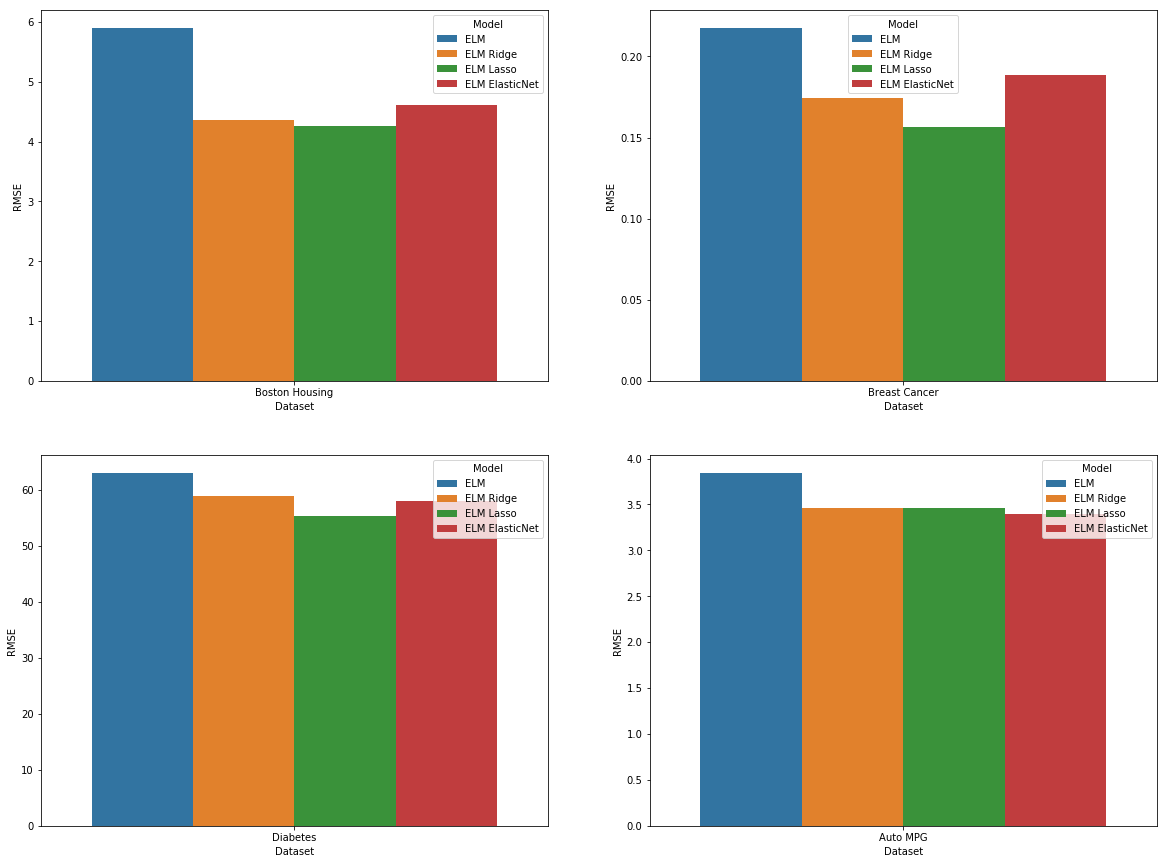

In [11]:
plt.figure(figsize=(20, 15))
for i, dataset in enumerate(results_df['Dataset'].unique()):
    plt.subplot(2, 2, i + 1)
    mask = results_df['Dataset'] == dataset
    sns.barplot(x='Dataset', y='RMSE', hue='Model', data=results_df[mask])
plt.show()

## Conclusion

We can see the results from the experiment from the bar plots above and the resulting dataset. On average regularized versions of the ELM show better test results, specially the Lasso.

These results can be due to the fact the traditional ELM might suffer from overfitting, thus dont acheive as good test results. We can see by the final dataset that not all ELMs favored the maximum number of neurons possible and that has to do with the fact that for these datasets specifically a sufficient capacity can be reached without this maximum number.

As an observation, adding neurons to a hidden layer of an ELM has a similar effect of adding polinomial terms to a linear regression, as previously discussed. The incurring problems with this extra capacity are also the same, which is to make the network more prone to overfitting the training set.

# References

[1] M. Martínez-Martínez, José and Escandell-Montero, Pablo and Olivas, Emilio and Martín-Guerrero, José and Magdalena, Rafael and Gómez-Sanchís, Juan - "Regularized extreme learning machine for regression problems" , Neurocomputing IJON 2011